In [1]:
# Install necessary libraries
!pip install pandas matplotlib seaborn scikit-learn torch prophet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.2 MB/s eta 0:00:00a 0:00:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
from prophet import Prophet


Importing plotly failed. Interactive plots will not work.


In [3]:
# Load GMSL data
gmsl_df = pd.read_csv('sealevel.csv')
gmsl_df.head()


,Year,TotalWeightedObservations,GMSL_noGIA,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved
0,1993,327401.31,-38.59,89.86,-38.76,-38.59,89.86,-38.75,-38.57
1,1993,324498.41,-41.97,90.86,-39.78,-41.97,90.86,-39.77,-39.11
2,1993,333018.19,-41.93,87.27,-39.62,-41.91,87.27,-39.61,-38.58
3,1993,297483.19,-42.67,90.75,-39.67,-42.65,90.74,-39.64,-38.34
4,1993,321635.81,-37.86,90.26,-38.75,-37.83,90.25,-38.72,-37.21


In [4]:
# Aggregate GMSL data by year (average)
gmsl_yearly = gmsl_df.groupby('Year').mean().reset_index()
gmsl_yearly.head()


,Year,TotalWeightedObservations,GMSL_noGIA,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved
0,1993,319044.908649,-34.605405,87.603784,-34.629459,-34.483784,87.607027,-34.507568,-34.508378
1,1994,323836.882162,-30.951081,87.412432,-30.898919,-30.584324,87.418919,-30.532432,-30.531892
2,1995,317986.154865,-28.645946,85.336757,-27.971351,-28.019459,85.337838,-27.359189,-27.358108
3,1996,323979.240278,-26.596389,84.194444,-26.140833,-25.744167,84.188611,-25.288611,-25.287222
4,1997,321345.634054,-22.682432,97.989189,-22.345946,-21.591081,98.000000,-21.254865,-21.255676


In [6]:
# Load temperature data
temp_df = pd.read_csv('GLB.Ts+dSST.csv')
temp_df.head()


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.20,-0.25,-0.09,-0.16,-0.09,-0.22,-0.20,-0.09,-.15,-.22,-.22,-.18,-.17,***,***,-0.11,-0.17,-.20
1,1881,-0.19,-0.15,0.02,0.04,0.07,-0.19,0.01,-0.04,-.16,-.22,-.18,-.07,-.09,-.10,-.18,0.04,-0.07,-.19
2,1882,0.16,0.14,0.05,-0.15,-0.13,-0.22,-0.16,-0.07,-.14,-.23,-.17,-.36,-.11,-.08,.08,-0.08,-0.15,-.18
3,1883,-0.29,-0.36,-0.12,-0.18,-0.18,-0.07,-0.07,-0.14,-.22,-.11,-.24,-.11,-.17,-.20,-.34,-0.16,-0.09,-.19
4,1884,-0.12,-0.08,-0.36,-0.40,-0.33,-0.35,-0.30,-0.28,-.27,-.25,-.33,-.30,-.28,-.27,-.10,-0.36,-0.31,-.28


In [7]:
# Replace '***' with NaN and convert to numeric
temp_df = temp_df.replace('***', np.nan)
columns_to_convert = temp_df.columns.drop('Year')
temp_df[columns_to_convert] = temp_df[columns_to_convert].apply(pd.to_numeric)

# Calculate annual average temperature anomaly
temp_df['TempAnomaly'] = temp_df[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].mean(axis=1)
temp_df.head()


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,TempAnomaly
0,1880,-0.20,-0.25,-0.09,-0.16,-0.09,-0.22,-0.20,-0.09,-0.15,-0.22,-0.22,-0.18,-0.17,NaN,NaN,-0.11,-0.17,-0.20,-0.172500
1,1881,-0.19,-0.15,0.02,0.04,0.07,-0.19,0.01,-0.04,-0.16,-0.22,-0.18,-0.07,-0.09,-0.10,-0.18,0.04,-0.07,-0.19,-0.088333
2,1882,0.16,0.14,0.05,-0.15,-0.13,-0.22,-0.16,-0.07,-0.14,-0.23,-0.17,-0.36,-0.11,-0.08,0.08,-0.08,-0.15,-0.18,-0.106667
3,1883,-0.29,-0.36,-0.12,-0.18,-0.18,-0.07,-0.07,-0.14,-0.22,-0.11,-0.24,-0.11,-0.17,-0.20,-0.34,-0.16,-0.09,-0.19,-0.174167
4,1884,-0.12,-0.08,-0.36,-0.40,-0.33,-0.35,-0.30,-0.28,-0.27,-0.25,-0.33,-0.30,-0.28,-0.27,-0.10,-0.36,-0.31,-0.28,-0.280833


In [8]:
# Merge datasets on 'Year'
merged_df = pd.merge(gmsl_yearly, temp_df[['Year', 'TempAnomaly']], on='Year')
merged_df.head()


,Year,TotalWeightedObservations,GMSL_noGIA,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved,TempAnomaly
0,1993,319044.908649,-34.605405,87.603784,-34.629459,-34.483784,87.607027,-34.507568,-34.508378,0.230000
1,1994,323836.882162,-30.951081,87.412432,-30.898919,-30.584324,87.418919,-30.532432,-30.531892,0.313333
2,1995,317986.154865,-28.645946,85.336757,-27.971351,-28.019459,85.337838,-27.359189,-27.358108,0.444167
3,1996,323979.240278,-26.596389,84.194444,-26.140833,-25.744167,84.188611,-25.288611,-25.287222,0.328333
4,1997,321345.634054,-22.682432,97.989189,-22.345946,-21.591081,98.000000,-21.254865,-21.255676,0.463333


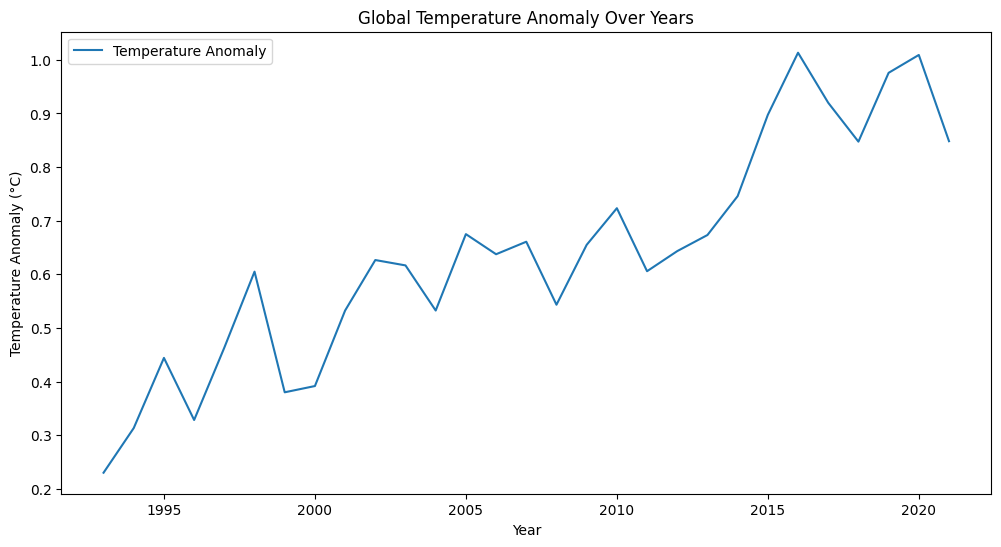

In [9]:
plt.figure(figsize=(12,6))
sns.lineplot(data=merged_df, x='Year', y='TempAnomaly', label='Temperature Anomaly')
plt.title('Global Temperature Anomaly Over Years')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()


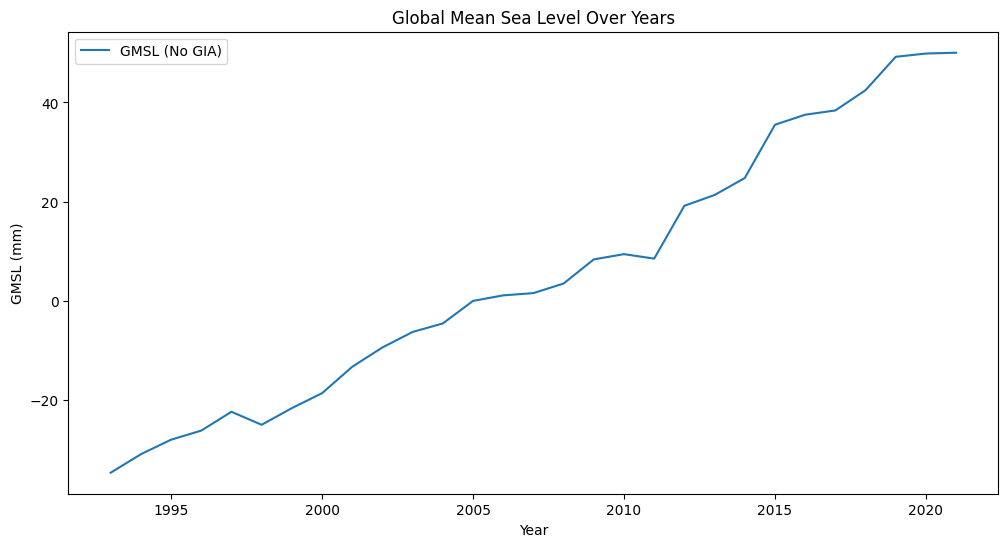

In [10]:
plt.figure(figsize=(12,6))
sns.lineplot(data=merged_df, x='Year', y='SmoothedGSML_noGIA', label='GMSL (No GIA)')
plt.title('Global Mean Sea Level Over Years')
plt.xlabel('Year')
plt.ylabel('GMSL (mm)')
plt.legend()
plt.show()


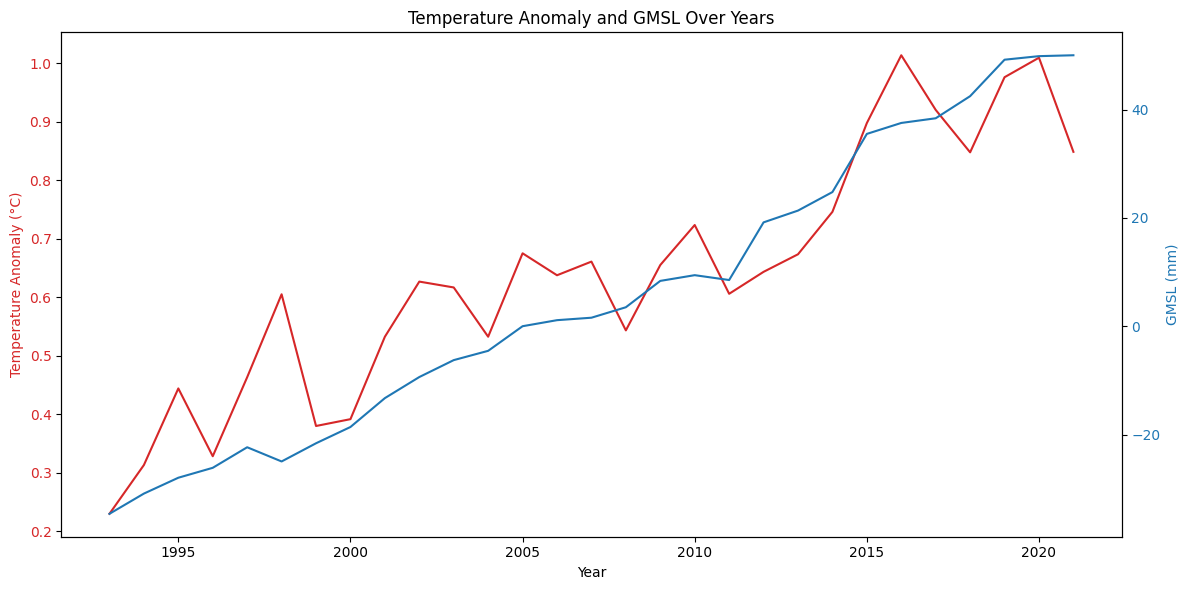

In [11]:
fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature Anomaly (°C)', color=color)
ax1.plot(merged_df['Year'], merged_df['TempAnomaly'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('GMSL (mm)', color=color)  # we already handled the x-label with ax1
ax2.plot(merged_df['Year'], merged_df['SmoothedGSML_noGIA'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Temperature Anomaly and GMSL Over Years')
fig.tight_layout()
plt.show()


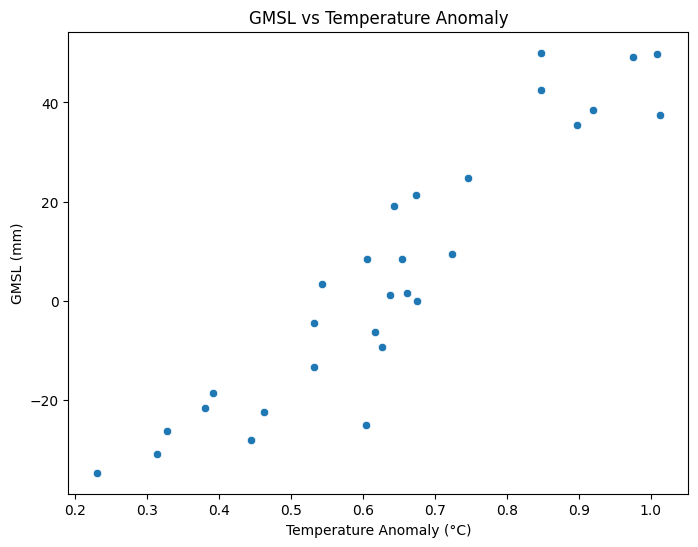

Correlation between Temperature Anomaly and GMSL: 0.93


In [12]:
# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x='TempAnomaly', y='SmoothedGSML_noGIA')
plt.title('GMSL vs Temperature Anomaly')
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('GMSL (mm)')
plt.show()

# Calculate correlation
correlation = merged_df['TempAnomaly'].corr(merged_df['SmoothedGSML_noGIA'])
print(f"Correlation between Temperature Anomaly and GMSL: {correlation:.2f}")


In [13]:
# Features and target
X = merged_df[['TempAnomaly']].values
y = merged_df['SmoothedGSML_noGIA'].values


In [14]:
# Create and train the model
lr_model = LinearRegression()
lr_model.fit(X, y)

# Predict
y_pred = lr_model.predict(X)


In [15]:
# Calculate metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Linear Regression MSE: {mse:.2f}")
print(f"Linear Regression R^2 Score: {r2:.2f}")


Linear Regression MSE: 92.92
Linear Regression R^2 Score: 0.87


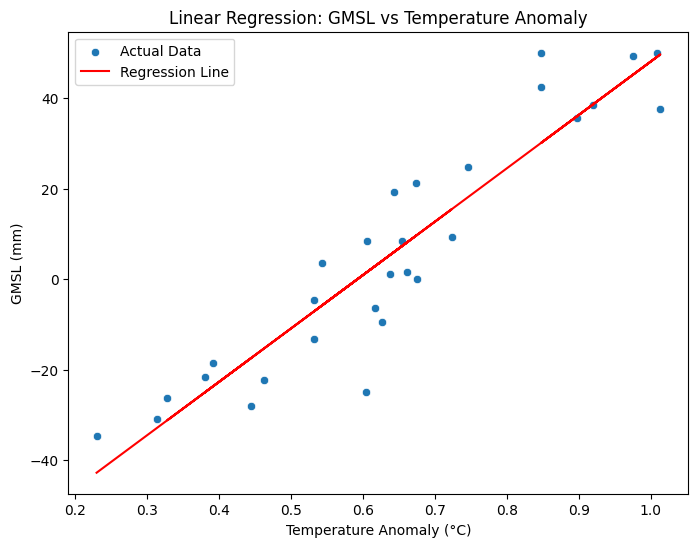

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X.flatten(), y=y, label='Actual Data')
plt.plot(X, y_pred, color='red', label='Regression Line')
plt.title('Linear Regression: GMSL vs Temperature Anomaly')
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('GMSL (mm)')
plt.legend()
plt.show()


In [17]:
# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)


In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 8)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(8, 1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

net = Net()


In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)


In [20]:
# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    # Forward pass
    outputs = net(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss (every 50 epochs)
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [50/500], Loss: 719.5399
Epoch [100/500], Loss: 714.6653
Epoch [150/500], Loss: 710.4434
Epoch [200/500], Loss: 706.8176
Epoch [250/500], Loss: 703.7315
Epoch [300/500], Loss: 701.1298
Epoch [350/500], Loss: 698.9588
Epoch [400/500], Loss: 697.1667
Epoch [450/500], Loss: 695.7047
Epoch [500/500], Loss: 694.5265


In [21]:
# Predict
net.eval()
with torch.no_grad():
    y_nn_pred = net(X_tensor).numpy()

# Calculate metrics
nn_mse = mean_squared_error(y, y_nn_pred)
nn_r2 = r2_score(y, y_nn_pred)

print(f"Neural Network MSE: {nn_mse:.2f}")
print(f"Neural Network R^2 Score: {nn_r2:.2f}")


Neural Network MSE: 694.51
Neural Network R^2 Score: -0.01


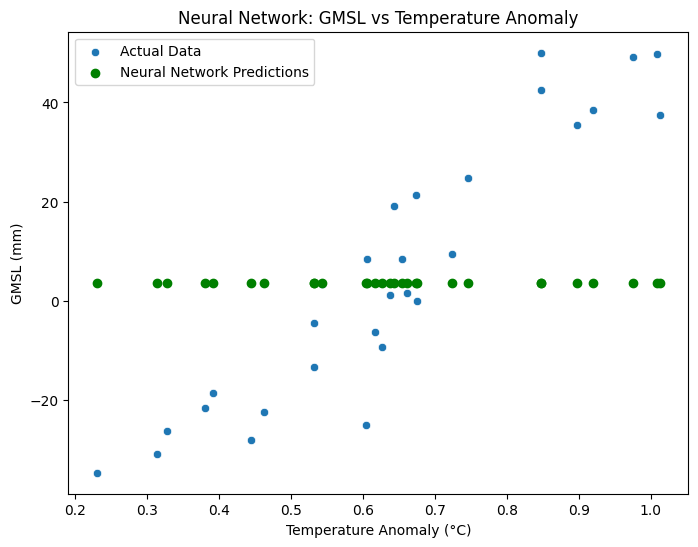

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X.flatten(), y=y, label='Actual Data')
plt.scatter(X, y_nn_pred, color='green', label='Neural Network Predictions')
plt.title('Neural Network: GMSL vs Temperature Anomaly')
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('GMSL (mm)')
plt.legend()
plt.show()


In [23]:
# Prepare data
gmsl_prophet_df = gmsl_yearly[['Year', 'SmoothedGSML_noGIA']].rename(columns={'Year': 'ds', 'SmoothedGSML_noGIA': 'y'})
gmsl_prophet_df['ds'] = pd.to_datetime(gmsl_prophet_df['ds'], format='%Y')
gmsl_prophet_df.head()


,ds,y
0,1993-01-01,-34.629459
1,1994-01-01,-30.898919
2,1995-01-01,-27.971351
3,1996-01-01,-26.140833
4,1997-01-01,-22.345946


In [24]:
# Initialize and fit the model
gmsl_model = Prophet()
gmsl_model.fit(gmsl_prophet_df)


19:58:58 - cmdstanpy - INFO - Chain [1] start processing
19:59:00 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# Create future dataframe
future_years = gmsl_model.make_future_dataframe(periods=10, freq='Y')
# Predict
gmsl_forecast = gmsl_model.predict(future_years)


/Users/ruwadnaswan/Desktop/fastApi/venv/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


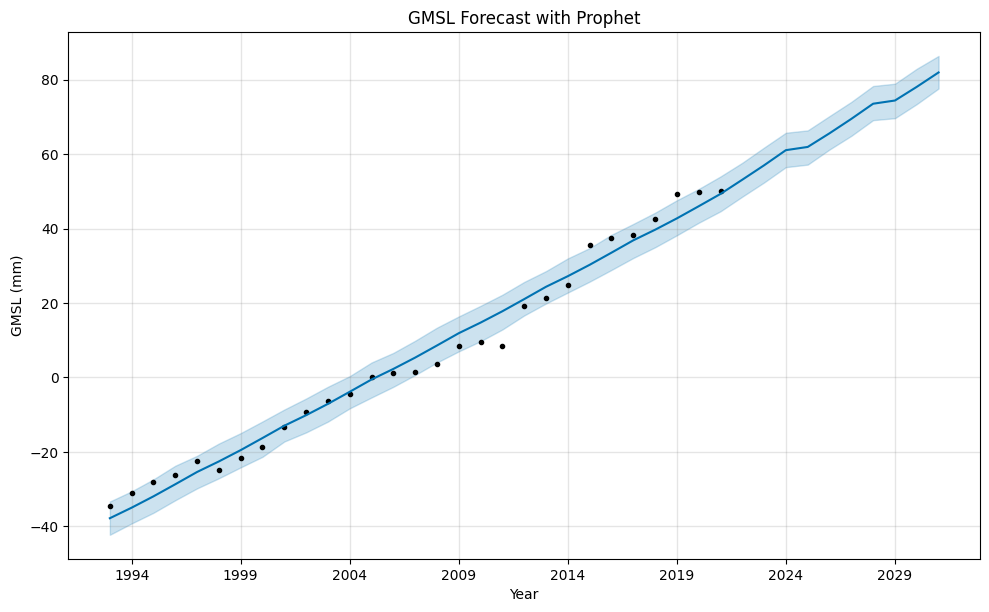

In [26]:
# Plot forecast
gmsl_model.plot(gmsl_forecast)
plt.title('GMSL Forecast with Prophet')
plt.xlabel('Year')
plt.ylabel('GMSL (mm)')
plt.show()


In [27]:
# Prepare data
temp_prophet_df = temp_df[['Year', 'TempAnomaly']].dropna().rename(columns={'Year': 'ds', 'TempAnomaly': 'y'})
temp_prophet_df['ds'] = pd.to_datetime(temp_prophet_df['ds'], format='%Y')
temp_prophet_df.head()


,ds,y
0,1880-01-01,-0.172500
1,1881-01-01,-0.088333
2,1882-01-01,-0.106667
3,1883-01-01,-0.174167
4,1884-01-01,-0.280833


In [28]:
# Initialize and fit the model
temp_model = Prophet()
temp_model.fit(temp_prophet_df)


20:00:21 - cmdstanpy - INFO - Chain [1] start processing
20:00:21 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# Create future dataframe
future_years_temp = temp_model.make_future_dataframe(periods=10, freq='Y')
# Predict
temp_forecast = temp_model.predict(future_years_temp)


/Users/ruwadnaswan/Desktop/fastApi/venv/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


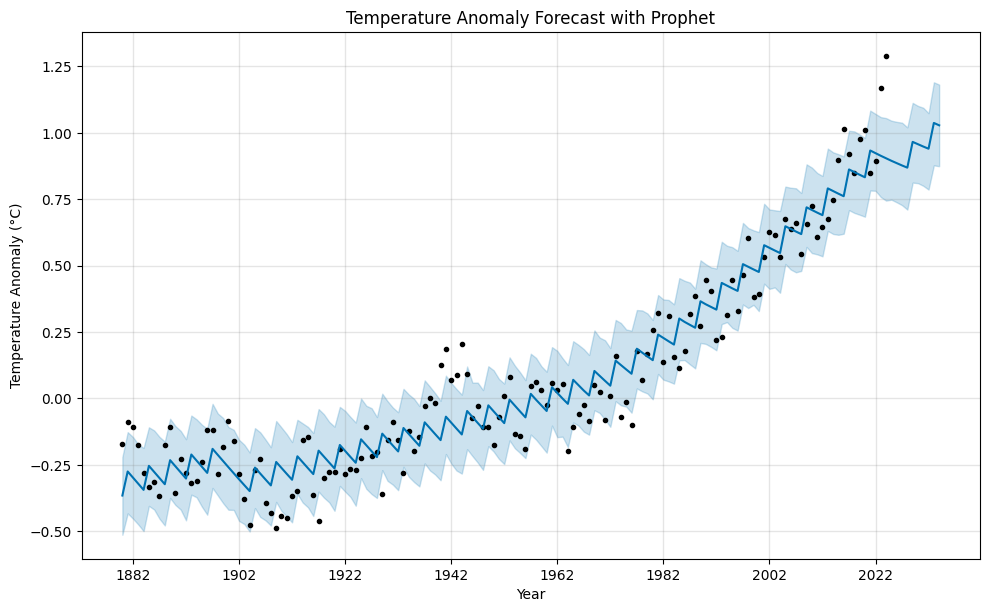

In [30]:
# Plot forecast
temp_model.plot(temp_forecast)
plt.title('Temperature Anomaly Forecast with Prophet')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.show()


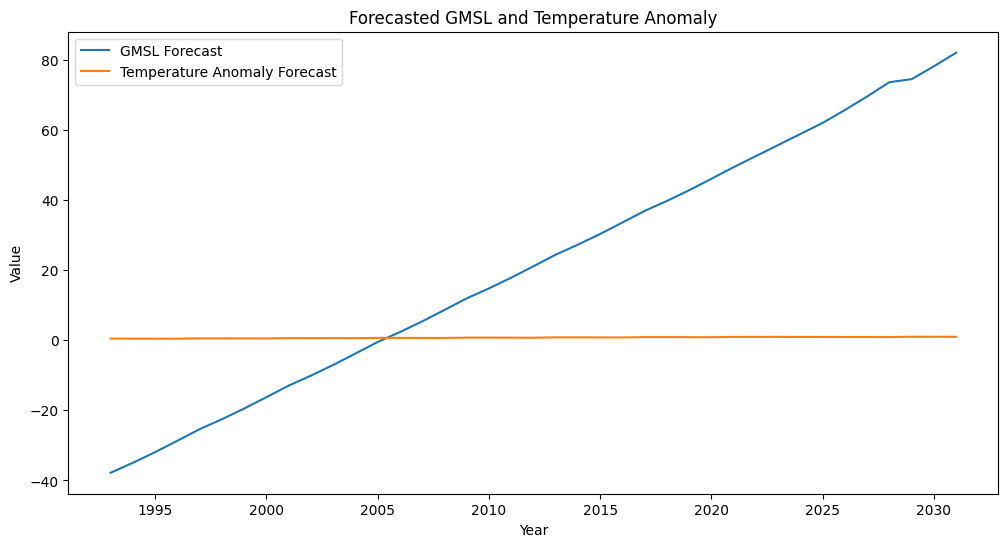

In [31]:
# Merge forecasts
forecast_merged = pd.merge(gmsl_forecast[['ds', 'yhat']], temp_forecast[['ds', 'yhat']], on='ds', suffixes=('_gmsl', '_temp'))

# Plot the forecasts together
plt.figure(figsize=(12,6))
plt.plot(forecast_merged['ds'], forecast_merged['yhat_gmsl'], label='GMSL Forecast')
plt.plot(forecast_merged['ds'], forecast_merged['yhat_temp'], label='Temperature Anomaly Forecast')
plt.title('Forecasted GMSL and Temperature Anomaly')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()
